In [83]:
%load_ext autoreload
%autoreload 2

import boto3
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import sys
import pickle

from run_utils import compute_across_trials_s3, plot_ratings_mses_s3
from run_utils import get_env_dataset

sys.path.append('../') 
from reclab.environments import LatentFactorBehavior 
from env_defaults import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib.font_manager
matplotlib.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
bigfont = 18
medfont = 14
smallfont = 12
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set_palette("muted")

from adjustText import adjust_text

In [ ]:
bucket_name = 'recsys-eval'
bucket = boto3.resource('s3').Bucket(bucket_name)
data_dir = 'Sarah'

In [ ]:
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

cmap = categorical_cmap(2,3)

# Plots for topics_static_lowdata

In [39]:
full_recommender_names = ['LibFM (SGD)', 
                          'LibFM (SGD) thompson,20','LibFM (SGD) thompson', 
                          'LibFM (SGD) eps_greedy', 'LibFM (SGD) eps_greedy,0.2', 
                          'LibFM (MCMC)',
                          'LibFM (MCMC) thompson,20','LibFM (MCMC) thompson',
                          'LibFM (MCMC) eps_greedy', 'LibFM (MCMC) eps_greedy,0.2',] 

labels = ['SGD Greedy', 
          'SGD TS(p=20)', 'SGD TS(p=8)', 
          'SGD $\epsilon$-Greedy(0.1)', 'SGD $\epsilon$-Greedy(0.2)', 
          'Bayesian Greedy', 
          'Bayesian TS(p=20)', 'Bayesian TS(p=8)', 
          'Bayesian $\epsilon$-Greedy(0.1)', 'Bayesian $\epsilon$-Greedy(0.2)']

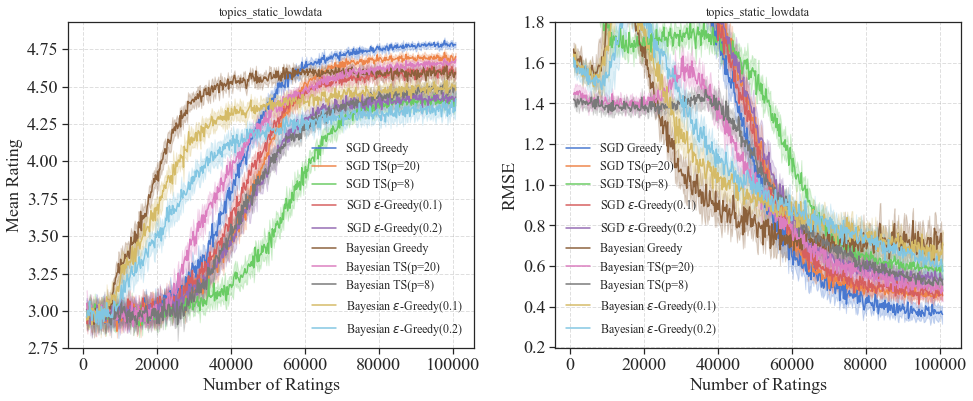

In [120]:
ENV_PARAMS = TOPICS_STATIC
env_name = ENV_PARAMS['name'] + '_lowdata'

# Experiment setup.
n_trials = 1
trial_seeds = [i for i in range(n_trials)]
num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings'] - 99000
len_trial = get_len_trial(ENV_PARAMS)
num_users, _ = get_num_users_items(ENV_PARAMS)


all_stats_topics = plot_ratings_mses_s3(full_recommender_names,
                                         labels,
                                         len_trial,
                                         bucket_name,
                                         data_dir,
                                         env_name,
                                         range(9),
                                         plot_dense=False,
                                         num_users=num_users,
                                         num_init_ratings=num_init_ratings,
                                         rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                                         threshold=10,
                                         title=[env_name, env_name])



SGD Greedy
SGD TS(p=20)
SGD TS(p=8)
SGD $\epsilon$-Greedy(0.1)
SGD $\epsilon$-Greedy(0.2)
Bayesian Greedy
Bayesian TS(p=20)
Bayesian TS(p=8)
Bayesian $\epsilon$-Greedy(0.1)
Bayesian $\epsilon$-Greedy(0.2)


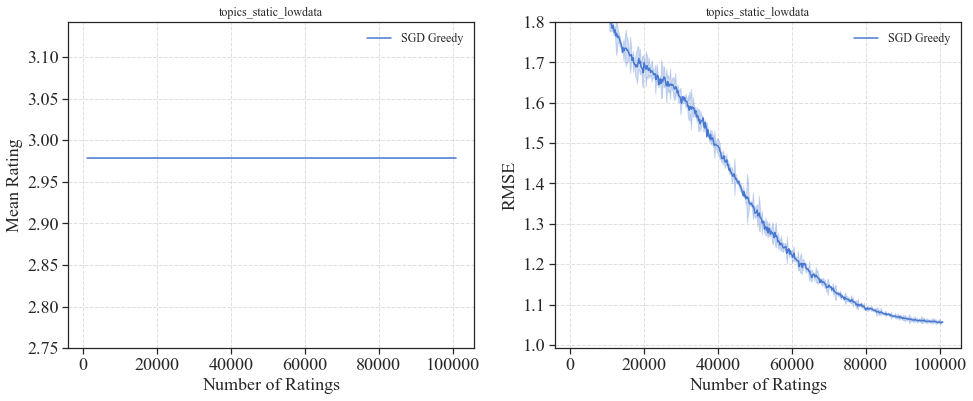

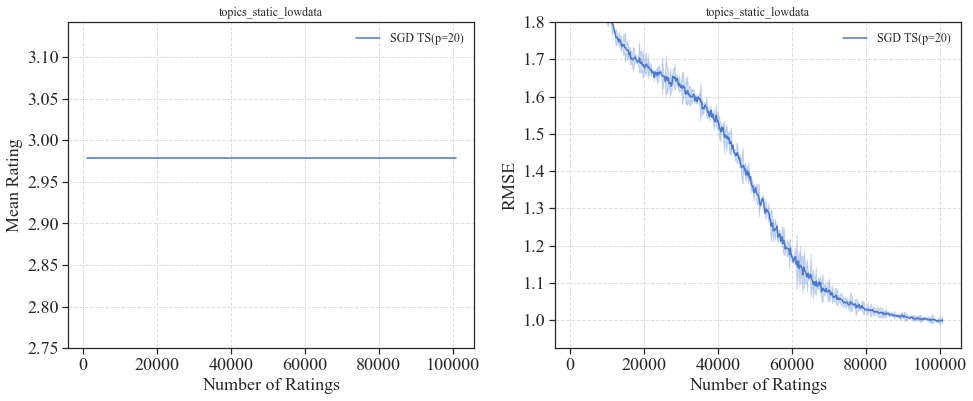

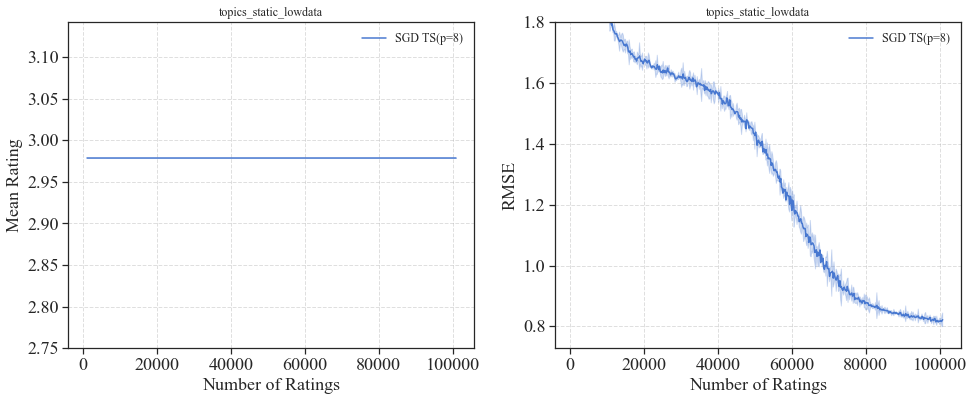

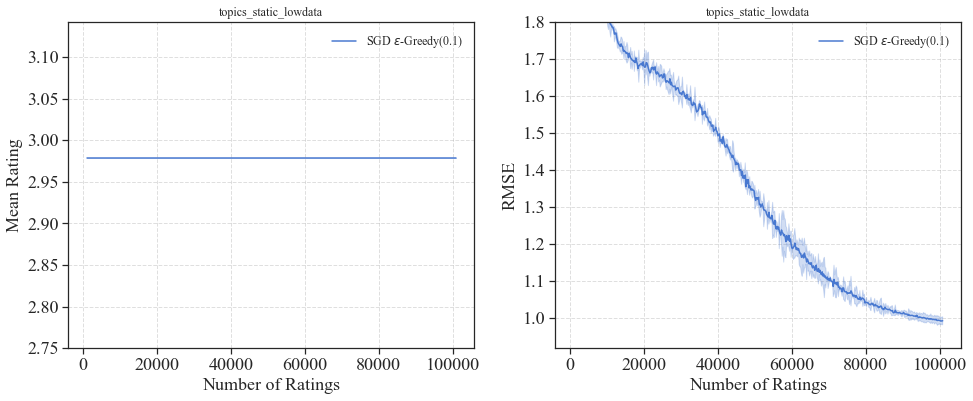

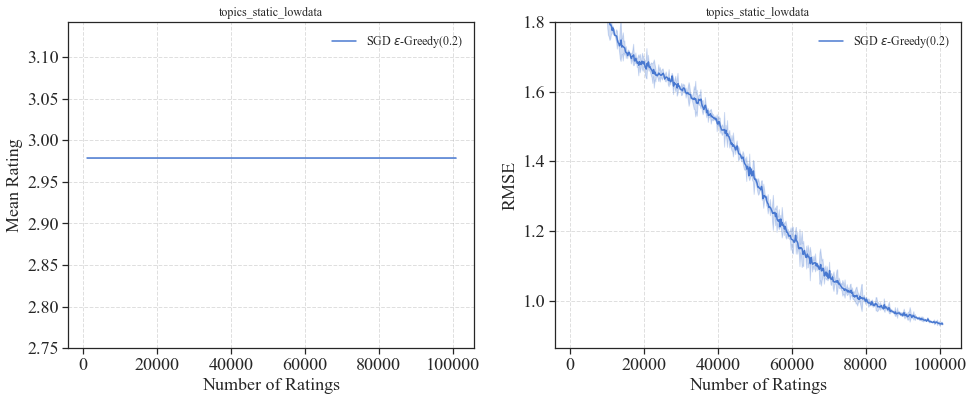

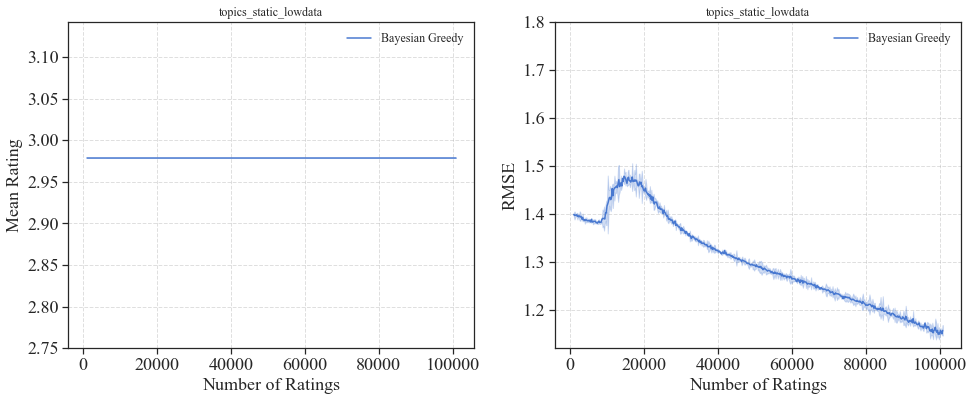

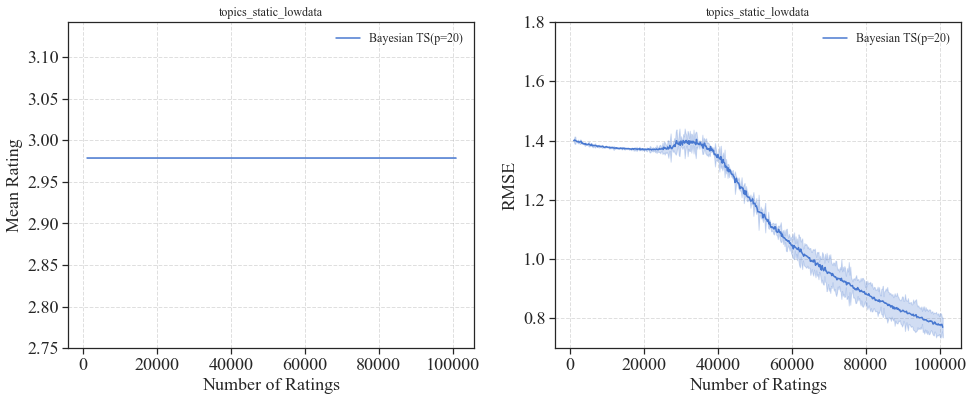

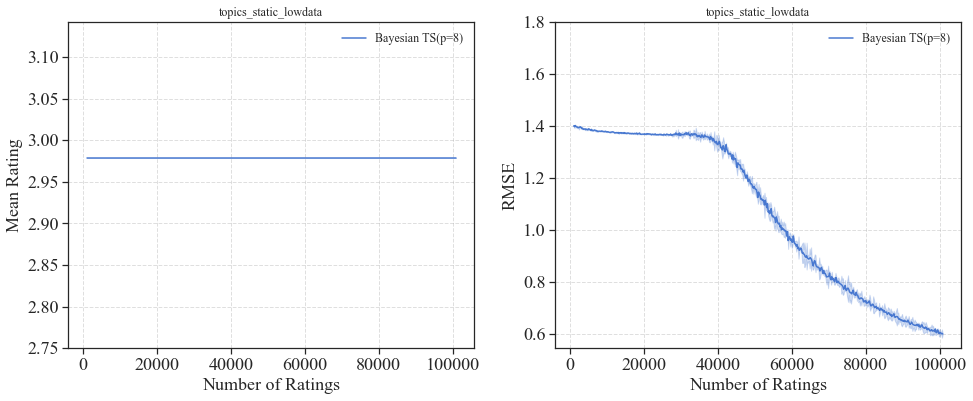

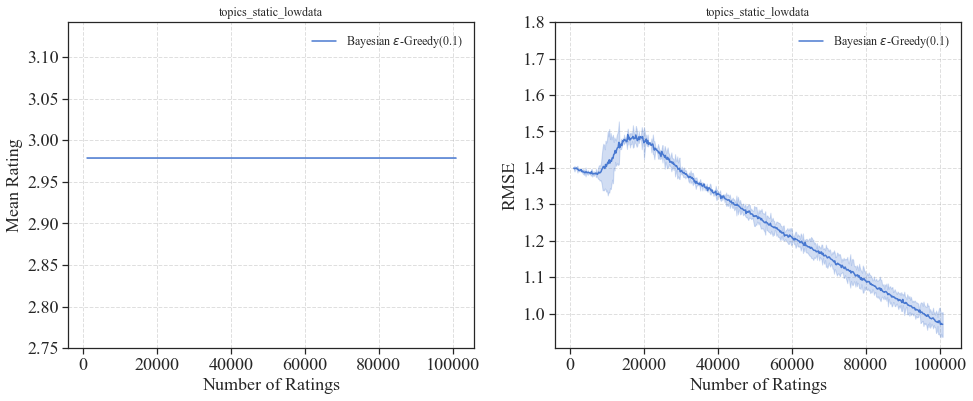

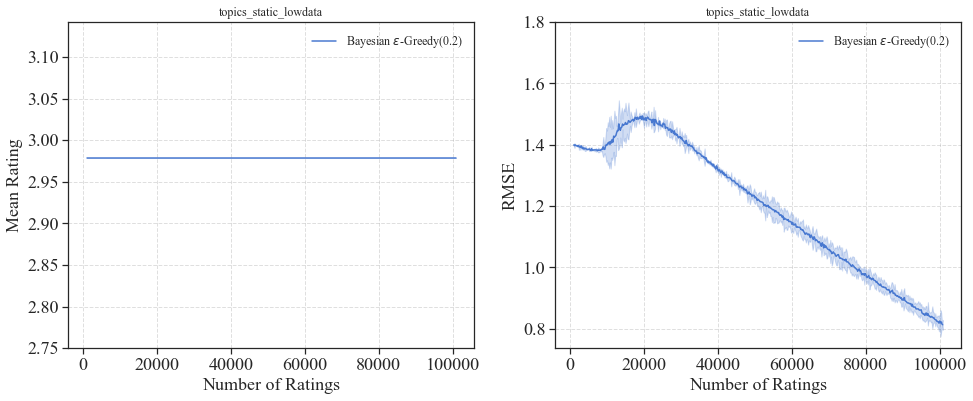

In [86]:
#TODO! this just takes a long time to run locally
RERUN = False

if RERUN:
    all_stats_dense = dict()
    for i in range(len(labels)):
        print(labels[i])
        stats_dense = plot_ratings_mses_s3([full_recommender_names[i]],
                                             [labels[i]],
                                             len_trial,
                                             bucket_name,
                                             data_dir,
                                             env_name,
                                             [0,2],
                                             plot_dense=True,
                                             num_users=num_users,
                                             num_init_ratings=num_init_ratings,
                                             rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                                             threshold=10,
                                             title=[env_name, env_name])
        pickle_out = open("dense_dict_{}.pickle".format(i),"wb")
        pickle.dump(stats_dense, pickle_out)
        pickle_out.close()
        all_stats_dense[labels[i]] = stats_dense[labels[i]]


In [67]:
def get_metrics_from_trials(all_stats, env_params=TOPICS_STATIC, cutoff=None):
    if cutoff is None:
        cutoff = int(1000 / (env_params['optional_params']['rating_frequency'] * num_users)) # 1000 ratings
    all_means = {}
    all_means_spread = {}
    all_rmses = {}
    all_rmses_spread = {}
    
    for label in all_stats.keys():
        means, lower_bounds, upper_bounds = all_stats[label]
        means = means[0]
        lower_bounds = lower_bounds[0]
        upper_bounds = upper_bounds[0]

        all_means[label] = (np.mean(means[:cutoff]), np.mean(means[-cutoff:]))
        all_means_spread[label] = (np.mean(lower_bounds[:cutoff]-upper_bounds[:cutoff]),
                                   np.mean(lower_bounds[-cutoff:]-upper_bounds[-cutoff:]))

        means, lower_bounds, upper_bounds = all_stats[label]
        mse = means[1]
        lower_bounds = lower_bounds[1]
        upper_bounds = upper_bounds[1]
        # Transform the MSE into the RMSE and correct the associated intervals.
        rmse = np.sqrt(mse)
        lower_bounds = np.sqrt(lower_bounds)
        upper_bounds = np.sqrt(upper_bounds)

        all_rmses[label] = (np.mean(rmse[:cutoff]), np.mean(rmse[-cutoff:]))
        all_rmses_spread[label] = (np.mean(lower_bounds[:cutoff]-upper_bounds[:cutoff]),
                                   np.mean(lower_bounds[-cutoff:]-upper_bounds[-cutoff:]))
        
    return(all_means, all_means_spread, all_rmses, all_rmses_spread)        

In [138]:
def plot_exploration_scatter(all_means, all_rmses, save=True,
                             fname = 'topics-static-exploration-scatter.pdf', cmap = None):    
    base_fig_height = 4
    base_fig_width = 5

    if cmap is None:
        cmap = categorical_cmap(2,3)
        
    plt.figure(figsize=(base_fig_width,base_fig_height))
    plt.xticks(fontsize=medfont)
    plt.yticks(fontsize=medfont)
    plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    
    labels=all_means.keys()
    rmses = [all_rmses[label][1] for label in labels  if 'SGD' in label ]
    means = [all_means[label][1] for label in labels if 'SGD' in label ]

    sizes = np.array([0.3, 0.6, 0.9, 0.6, 0.9])*100
    sgd_colors = [cmap(i) for i in [0,1,2,1,2]]
    plt.scatter(rmses, means, color=sgd_colors, label='SGD MF', edgecolors='k',s = sizes)

    rmses = [all_rmses[label][1] for label in labels if 'Bayesian' in label ]
    means = [all_means[label][1] for label in labels if 'Bayesian' in label]

    bayes_colors = [cmap(i+3) for i in [0,1,2,1,2]]
    plt.scatter(rmses, means, color=bayes_colors, label='Bayesian MF',  edgecolors='k',s = sizes)
    plt.legend(fontsize=smallfont,)
    plt.xlabel("Final RMSE", fontsize=bigfont)
    plt.ylabel("Final Mean Rating", fontsize=bigfont)

    rmses = [all_rmses[label][1] for label in labels]
    means = [all_means[label][1] for label in labels]

    rmses = [all_rmses[label][1] for label in labels]
    means = [all_means[label][1] for label in labels]

    rec_names = []
    for i, rec_name in enumerate(labels):
        rec_name = rec_name.split(' ')[1]     
        rec_names.append(rec_name)

    rec_label_texts = [plt.text(rmses[i], means[i], rec_names[i],
                                fontsize=medfont-1) for i in range(len(rec_names))]
    adjust_text(rec_label_texts,ha='left', 
                                va='bottom',
                                expand_points = (1.07, 1.35))

    plt.tight_layout()
    if save:
        plt.savefig(fname, bbox_inches='tight')

In [125]:
def plot_lollipop(all_rmses, save=True,
                  fname = 'topics-static-exploration-dense.pdf', cmap = None):
    
    base_fig_height = 4
    base_fig_width = 5
    if cmap is None:
        cmap = categorical_cmap(2,3)

    plt.figure(figsize=[0.19*base_fig_width/0.3,base_fig_height])

    ax = plt.subplot(1,1,1)
    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)

    labels = all_rmses.keys()
    label_ticks = [label.split(' ')[1]  if len(label.split()) > 1 else '{} Greedy'.format(label) for label in labels]
    N = len(label_ticks)
    ticks1 = list(reversed(np.arange(N//2))) 
    ticks2 = list(reversed(np.arange(N//2+1, N+1)))
    ticks = ticks1 + ticks2

    heights1 = [all_rmses[label][1] for label in labels if 'SGD' in label]
    heights2 = [all_rmses[label][1] for label in labels if 'Bayesian' in label]
    heights = heights1 + heights2

    plt.hlines(y=ticks,xmin=0,xmax=heights)

    sgd_colors = [cmap(i) for i in [0,1,2,1,2]]
    bayes_colors = [cmap(i+3) for i in [0,1,2,1,2]]
    for i, c in enumerate(sgd_colors):
        plt.plot(heights1[i], ticks1[i], "o", color=c, label='SGD MF', markersize=10, mec='k')
    for i, c in enumerate(bayes_colors):    
        plt.plot(heights2[i], ticks2[i], "o", color=c, label='Bayesian MF', markersize=10, mec='k')



    plt.yticks(ticks, label_ticks)
    plt.xlabel('Final population RMSE', fontsize=medfont+3)
    extent = [np.min(heights), np.max(heights)]
    xrange = [extent[0] - 0.25*np.diff(extent), extent[1] + 0.25*np.diff(extent)]
    plt.xlim(xrange); plt.ylim([-1, max(ticks)+1])
    plt.xticks(fontsize=bigfont)
    plt.yticks(fontsize=medfont+1)

    plt.tight_layout()
    if save:
        plt.savefig(fname, bbox_inches='tight')

In [139]:
def plot_timeseries(all_stats, env_params = TOPICS_STATIC, save=True,
                  fname = 'topics-static-exploration-timeseries.pdf', cmap = None):
    
    labels = ['SGD Greedy', 
              'SGD TS(p=20)',
              'Bayesian Greedy', 
              'Bayesian TS(p=20)']
    if cmap is None:
        cmap = categorical_cmap(2,3)
    rgblist = [cmap(0), cmap(1), cmap(3), cmap(4)]
    x_vals = num_init_ratings + num_users * ENV_PARAMS['optional_params']['rating_frequency'] * np.arange(len_trial)

    plt.figure(figsize=[0.49*base_fig_width/0.3,base_fig_height])
    plt.subplot(1, 1, 1)
    
    for label, rgb in zip(labels, rgblist):
        means, lower_bounds, upper_bounds = all_stats[label]
        means = means[0]
        lower_bounds = lower_bounds[0]
        upper_bounds = upper_bounds[0]
        plt.plot(x_vals, means, label=label, color=rgb)
        plt.fill_between(x_vals, lower_bounds, upper_bounds, alpha=0.25, color=rgb)
    plt.xticks(fontsize=bigfont)
    plt.yticks(fontsize=bigfont)
    plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    plt.xlabel('Number of Ratings', fontsize=bigfont)
    plt.ylabel('Mean Rating', fontsize=bigfont)
    plt.ylim(bottom=2.75)
    plt.legend(fontsize=medfont, markerscale=1, framealpha=1, frameon=False)
    if save:
        plt.savefig(fname, bbox_inches='tight')

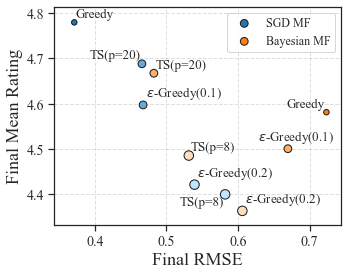

In [140]:
(topics_all_means, _, topics_all_rmses, _) = get_metrics_from_trials(all_stats_topics, TOPICS_STATIC)
plot_exploration_scatter(topics_all_means, topics_all_rmses)

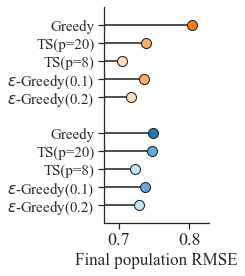

In [122]:
(topics_all_means_dense, _, topics_all_rmses_dense, _) = get_metrics_from_trials(all_stats_dense, TOPICS_STATIC)
plot_lollipop(topics_all_rmses_dense, save=False)

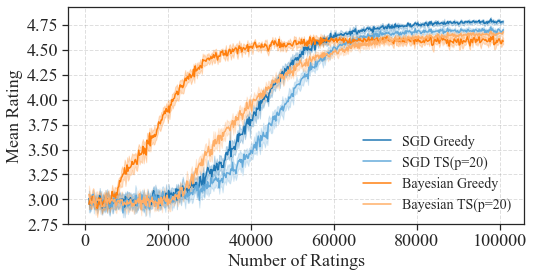

In [123]:
plot_timeseries(all_stats_topics)

### Plot latent static

/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


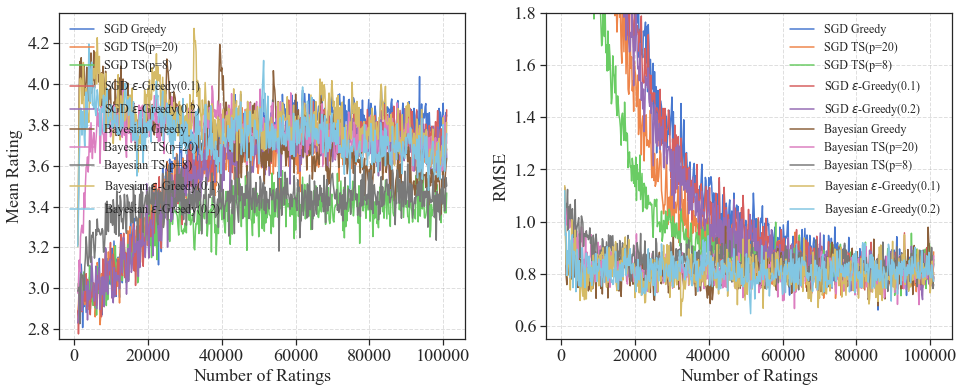

In [103]:
ENV_PARAMS = LATENT_STATIC
env_name = ENV_PARAMS['name'] + '_lowdata'
num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings'] - 99000
len_trial = get_len_trial(ENV_PARAMS)
num_users, _ = get_num_users_items(ENV_PARAMS)
all_stats_latent = plot_ratings_mses_s3(full_recommender_names,
                     labels,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10);

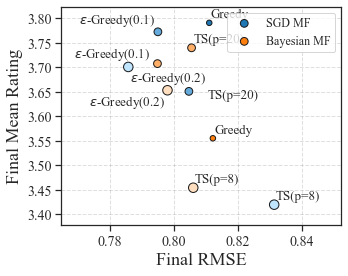

In [141]:
(latent_all_means, _, latent_all_rmses, _) = get_metrics_from_trials(all_stats_latent, LATENT_STATIC)
plot_exploration_scatter(latent_all_means, latent_all_rmses, 
                         fname='latent-static-exploration-scatter.pdf')

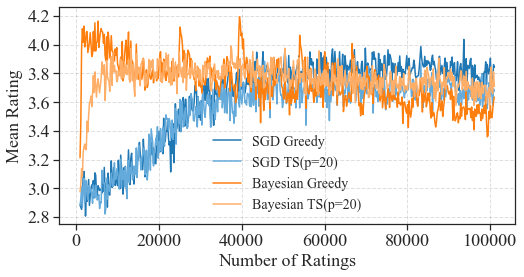

In [112]:
plot_timeseries(all_stats_latent, fname='latent-static-exploration-timeseries.pdf')

SGD Greedy


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


SGD TS(p=20)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


SGD TS(p=8)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


SGD $\epsilon$-Greedy(0.1)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


SGD $\epsilon$-Greedy(0.2)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Bayesian Greedy


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Bayesian TS(p=20)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Bayesian TS(p=8)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Bayesian $\epsilon$-Greedy(0.1)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Bayesian $\epsilon$-Greedy(0.2)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


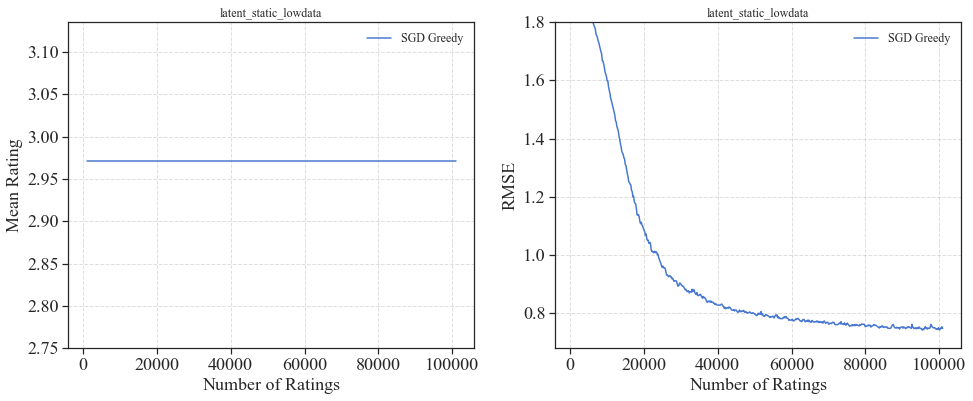

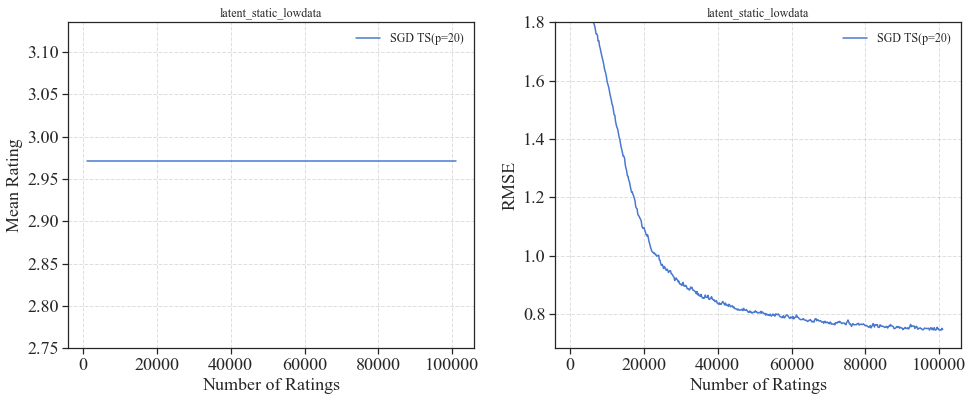

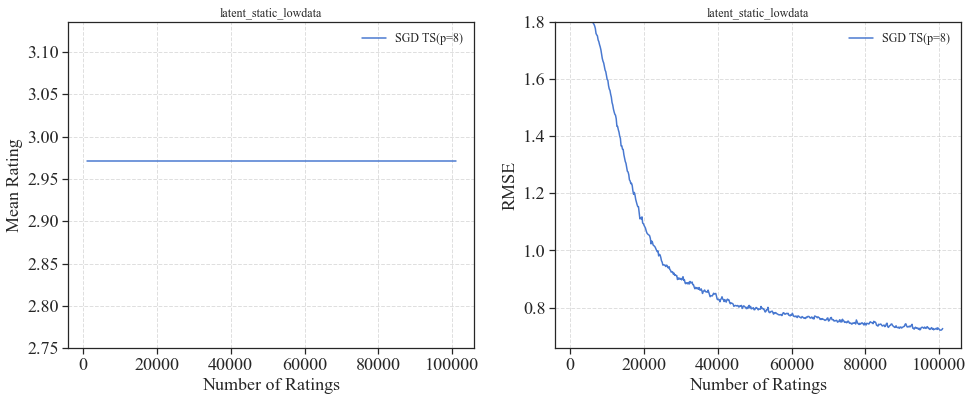

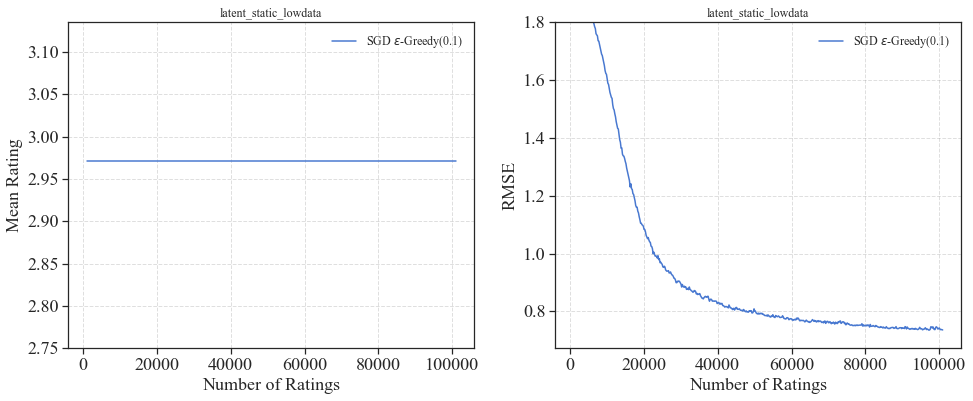

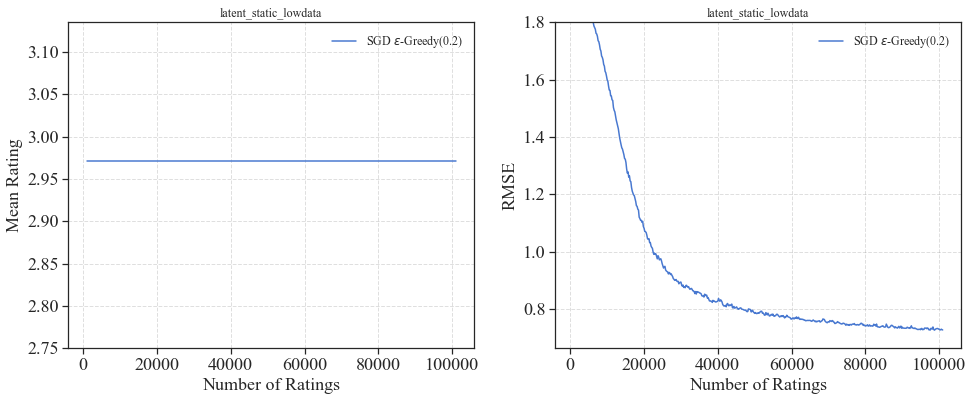

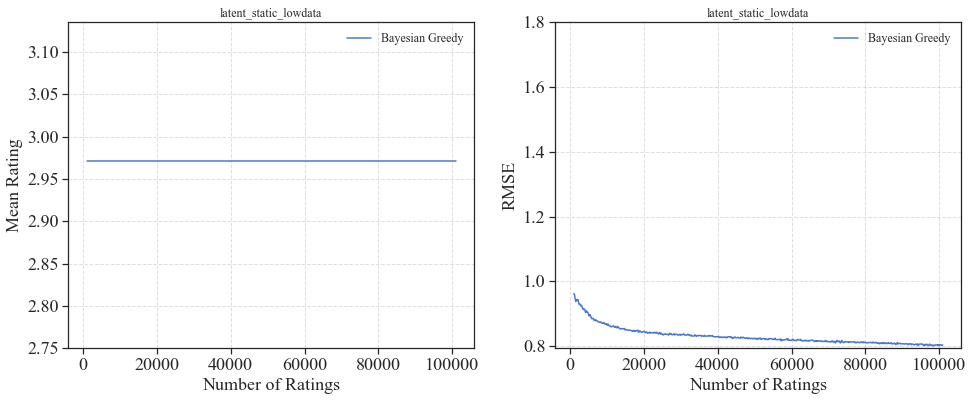

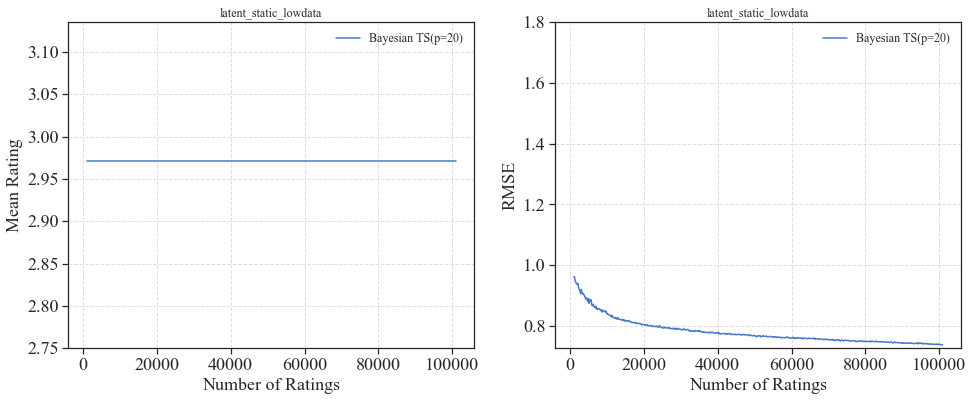

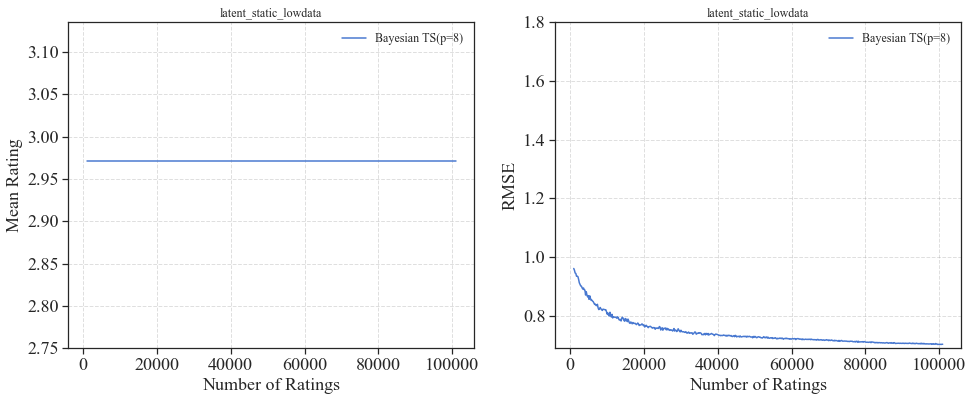

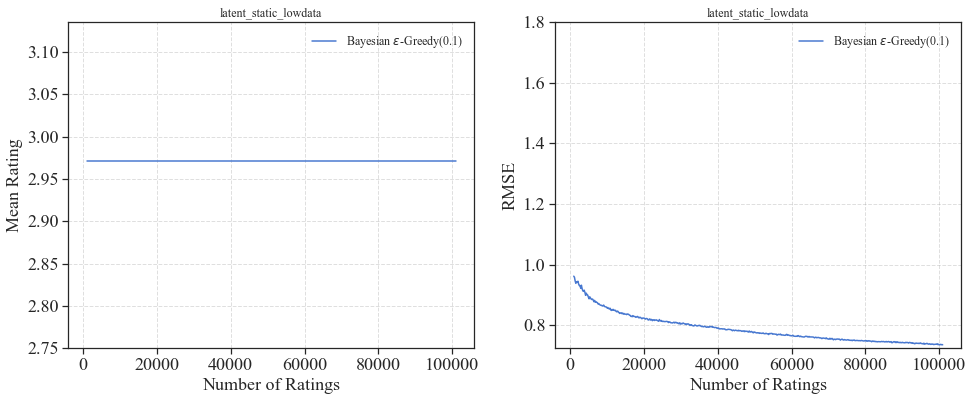

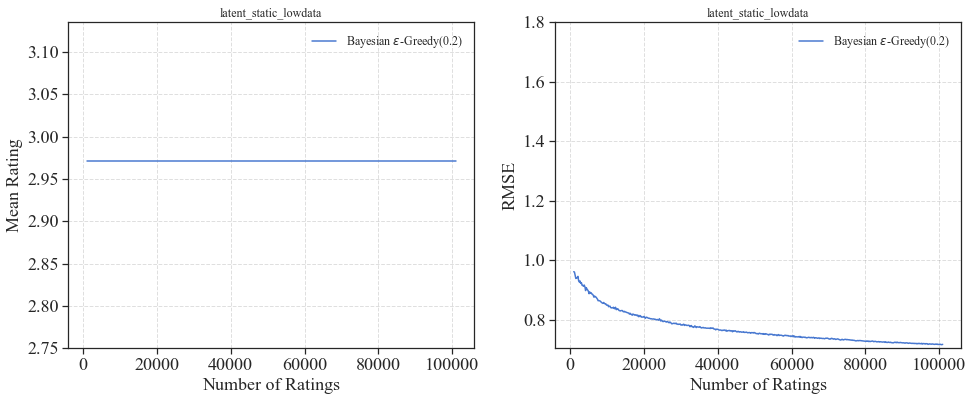

In [110]:
RERUN = True

if RERUN:
    all_stats_dense_latent = dict()
    for i in range(len(labels)):
        print(labels[i])
        stats_dense = plot_ratings_mses_s3([full_recommender_names[i]],
                                             [labels[i]],
                                             len_trial,
                                             bucket_name,
                                             data_dir,
                                             env_name,
                                             [0],
                                             plot_dense=True,
                                             num_users=num_users,
                                             num_init_ratings=num_init_ratings,
                                             rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                                             threshold=10,
                                             title=[env_name, env_name])
        pickle_out = open("latent_dense_dict_{}.pickle".format(i),"wb")
        pickle.dump(stats_dense, pickle_out)
        pickle_out.close()
        all_stats_dense[labels[i]] = stats_dense[labels[i]]

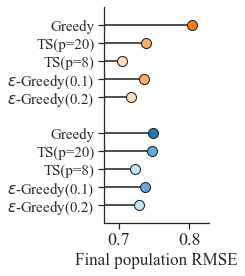

In [111]:
(latent_all_means_dense, _, latent_all_rmses_dense, _) = get_metrics_from_trials(all_stats_dense, TOPICS_STATIC)
plot_lollipop(latent_all_rmses_dense, fname='latent-static-exploration-dense.pdf')